# Filenames

In [1]:
result_name = 'Results/gesamt.csv'
times_name = 'Times/Milestone 4/Workstations/15_times_128_2.0.csv'
cities_name = 'city_coord.csv'

# Colors

In [2]:
burgundy = (.5647058823529412, .047058823529411764, .24705882352941178, 1)
green = (.3411764705882353, .7803921568627451, .5215686274509804, 1)
yellow = (1, .7647058823529411, 0, 0.5)
blue = (0, .7294117647058823, .6784313725490196, 0.8)
orange = (1, .3411764705882353, .2, 1)
transp = (1, .3411764705882353, .2, 0)

In [3]:
def get_csv_data(filename):
    csv_data = {
        "col_names" : [],
        "data" : [],
    }
    fl = True
    
    with open(filename, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if fl:
                csv_data["col_names"] = row
                fl = False
            else:
                if len(row) == len(csv_data["col_names"]):
                    csv_data["data"].append(row)
    
    csvfile.close()
    return csv_data

# Results

In [4]:
import csv, pandas as pd, matplotlib.pyplot as plt, numpy as np

In [5]:
# data has to be of shape (n, 7)
# order of 7 columns have to be ['num_cities', 'num_procs', 'speed', 'num_cores', 'CPU', 'length', 'route']

class Results:
    def __init__(self, data, figsize=(10,5), milestone="all"):
        columns = ['num_cities', 'num_procs', 'speed', 'step', 'milestone', 'length', 'route']
        self.original_data = pd.DataFrame(data = data, columns=columns)
        self.original_data['num_cities'] = pd.to_numeric(self.original_data['num_cities'])
        self.original_data['num_procs'] = pd.to_numeric(self.original_data['num_procs'])
        self.original_data['speed'] = pd.to_numeric(self.original_data['speed'], downcast="float")
        self.original_data['step'] = pd.to_numeric(self.original_data['step'], downcast="float")
        self.original_data['length'] = pd.to_numeric(self.original_data['length'], downcast="float")        
        self.filtered_data = self.original_data[['num_cities', 'num_procs', 'speed', 'step', 'milestone']]
        if milestone != "all":
            self.filtered_data = self.filtered_data.loc[self.filtered_data["milestone"]==milestone]
            self.milestone = int(milestone[-1:])
            
        self.routes = [[int(n), float(l), list(np.r_[[int(i) for i in r.split()], 0])] for n, l, r in self.original_data[['num_cities', 'length', 'route']].drop_duplicates().to_numpy()]
        self.figsize = figsize
        
    def set_figsize(self, figsize):
        self.figsize = figsize
        
    def print_labels(self):
        print(list(self.original_data.columns))
        
    def print_original_data(self):
        pd.set_option('display.max_rows', self.original_data.shape[0])
        print(self.original_data)
        
    def print_filtered_data(self):
        pd.set_option('display.max_rows', self.filtered_data.shape[0])
        print(self.filtered_data)
        
    def print_routes(self):
        print(self.routes)
        
    def get_routes(self):
        return self.routes
        
    def get_filtered_data(self):
        return self.filtered_data
    
    # step = float
    def get_df_by_city(self, num_cities, step):
        print_df = self.filtered_data.loc[self.filtered_data["num_cities"]==num_cities]
        print_df = print_df.loc[self.filtered_data["step"]==step].groupby(["num_cities", "num_procs", "step"]).mean()
        t_ref = print_df[np.in1d(print_df.index.get_level_values(1),1)]['speed'].values[0]        
        print_df["t_perfekt"] = t_ref / print_df.index.get_level_values(1)
        print_df['Speedup'] = t_ref / print_df["speed"]
        print_df['Efficiency'] = print_df['Speedup'] / print_df.index.get_level_values(1)
        return print_df

    # step = float
    def print_eval(self, num_cities, step=0):
        if self.milestone < 4:
            step=0
        print(self.get_df_by_city(num_cities, step))
        
    # step = tuple of floats, colors = tuple of color tuples
    def plot_time(self, num_cities, steps=[0], colors=[burgundy]):
        plt.figure(figsize=self.figsize)
        plt.title("Number of cities tested: " + str(num_cities) + " - Average duration")
        plt.ylabel("Time in s")
        plt.xlabel("Number of processes")
        if self.milestone < 4:
            length = 1
            steps=[0]
            colors=[burgundy]
        else:
            length = len(steps)
        for j in range(length):
            city_df = self.get_df_by_city(num_cities, steps[j])
            plt.plot([0, max(list(city_df.index.get_level_values(1)))],[city_df['speed'][0], city_df['speed'][0]], c= colors[j])
            plt.scatter(list(city_df.index.get_level_values(1)), city_df['speed'], c=[colors[j] for i in city_df['speed']], label="Measured time (step: " + str(steps[j]) + ")")
            plt.scatter(list(city_df.index.get_level_values(1)), city_df["t_perfekt"], c=[orange for i in city_df['speed']], label="Perfect time (step: " + str(steps[j]) + ")")
        
        plt.legend(loc=1)
        plt.grid()
        plt.show()
        
    # step = tuple of floats
    def plot_speedup(self, num_cities, steps=[0], colors=[burgundy], limit=128):
        plt.figure(figsize=self.figsize)
        plt.title("Number of cities tested: " + str(num_cities) + " - Speedup")
        plt.ylabel("Speedup")
        plt.xlabel("Number of processes")
        plt.ylim((0, limit))
        if self.milestone < 4:
            length = 1
            steps=[0]
            colors=[burgundy]
        else:
            length = len(steps)
        for j in range(length):
            city_df = self.get_df_by_city(num_cities, steps[j])
            plt.scatter(list(city_df.index.get_level_values(1)), city_df['Speedup'],c=[colors[j] for i in city_df['speed']], label="Calculated speedup (step: " + str(steps[j]) + ")")
            
        xy = np.arange(1, max(list(city_df.index.get_level_values(1))))
        plt.scatter(xy, xy,c=[blue for i in xy], label="Optimal speedup")
        plt.legend(loc=9)
        plt.grid()
        plt.show()
        
    # step = tuple of floats
    def plot_efficiency(self, num_cities, steps=[0], colors=[burgundy], limit=1):
        plt.figure(figsize=self.figsize)
        plt.title("Number of cities tested: " + str(num_cities) + " - Efficiency")
        plt.ylabel("Efficiency in %")
        plt.xlabel("Number of processes")
        plt.ylim((0, limit))
        if self.milestone < 4:
            length = 1
            steps=[0]
            colors=[burgundy]
        else:
            length = len(steps)
        for j in range(length):
            city_df = self.get_df_by_city(num_cities, steps[j])
            plt.scatter(list(city_df.index.get_level_values(1)), city_df['Efficiency']*100,c=[colors[j] for i in city_df['speed']], label="Efficiency (step: " + str(steps[j]) + ")")
        
        plt.scatter(list(city_df.index.get_level_values(1)), [100 for i in list(city_df.index.get_level_values(1))],c=[blue for i in list(city_df.index.get_level_values(1))], label="Maximal efficiency")
        plt.legend(loc=5)
        plt.grid()
        plt.show()

In [6]:
result_data = get_csv_data(result_name)
results = Results(result_data["data"], milestone="Milestone 2")

In [7]:
results.print_labels()

['num_cities', 'num_procs', 'speed', 'step', 'milestone', 'length', 'route']


In [8]:
cities = 17

In [9]:
results.print_eval(cities, step=2)

                                 speed   t_perfekt   Speedup  Efficiency
num_cities num_procs step                                               
17         1         0.0    443.788696  443.788696  1.000000    1.000000
           2         0.0    653.683533  221.894348  0.678905    0.339452
           3         0.0    690.598938  147.929565  0.642614    0.214205
           4         0.0    674.090637  110.947174  0.658352    0.164588
           5         0.0    673.358948   88.757739  0.659067    0.131813
           6         0.0   1045.505493   73.964783  0.424473    0.070745
           7         0.0    969.582153   63.398385  0.457711    0.065387
           8         0.0    855.641296   55.473587  0.518662    0.064833
           9         0.0   1298.687622   49.309855  0.341721    0.037969
           10        0.0   1481.396240   44.378870  0.299575    0.029957
           16        0.0   1055.938477   27.736794  0.420279    0.026267
           32        0.0    750.518066   13.868397 

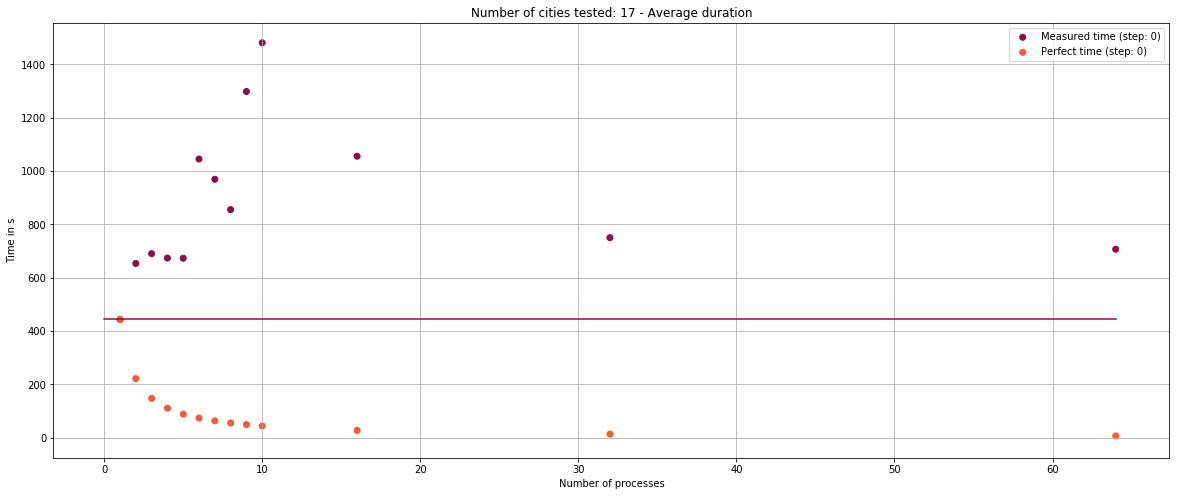

In [10]:
results.set_figsize((20,8))
results.plot_time(cities, [0.5, 2], [burgundy, green])

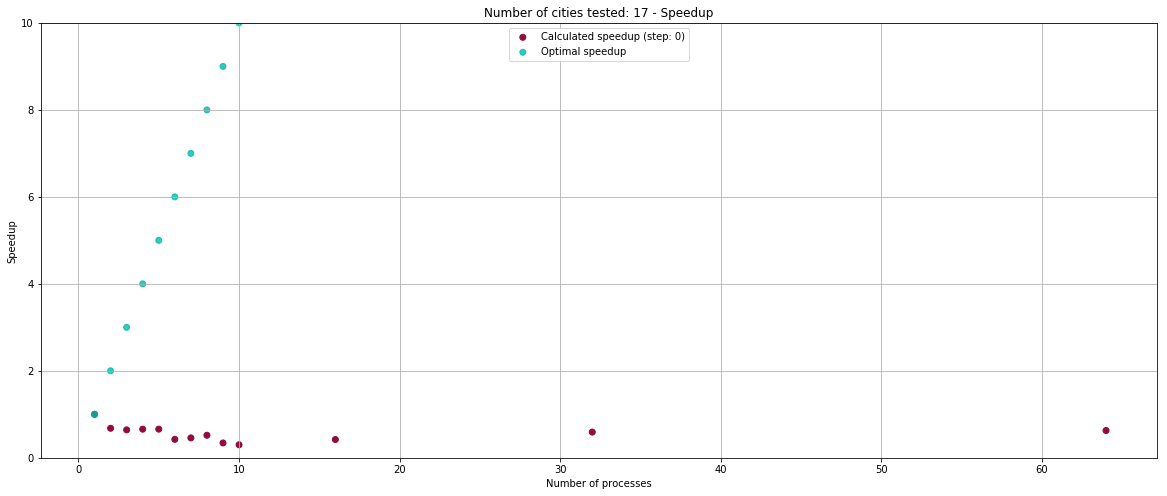

In [11]:
results.plot_speedup(cities, [0.5,2], [burgundy, green], limit=10)

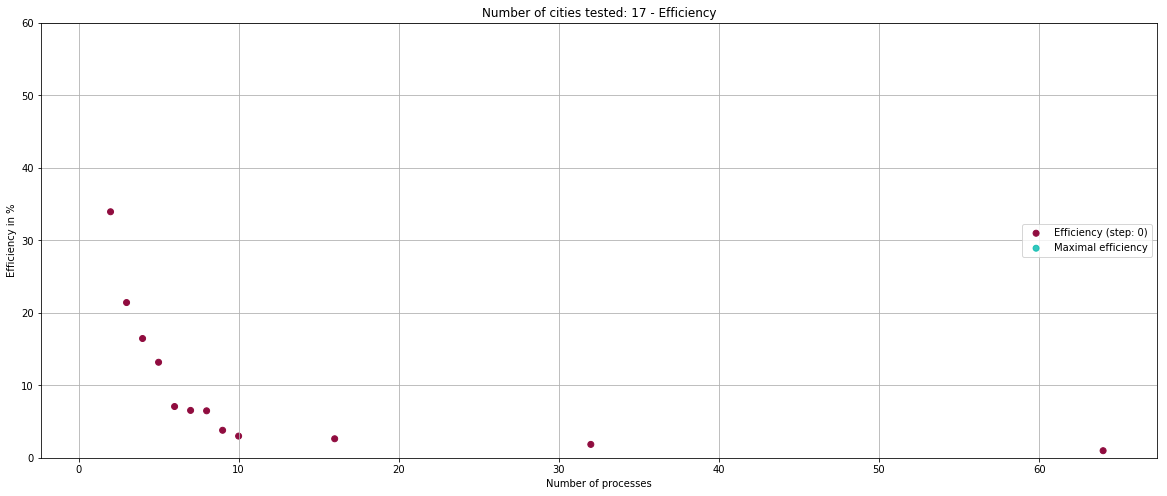

In [12]:
results.plot_efficiency(cities, [0.5, 2], [burgundy, green], limit=60)

# Times

In [13]:
class Times:
    def __init__(self, data):
        self.original_data = pd.DataFrame(data = data["data"], columns=data["col_names"])
        
        for col in self.original_data.columns:
            self.original_data[col] = pd.to_numeric(self.original_data[col])
        
        self.original_data = self.original_data.groupby("RANK").mean()        
        self.data_array = list(np.transpose(self.original_data.to_numpy()))
        self.width = 0.3
        self.idx = np.arange(self.original_data.shape[0])
        
    def print_labels(self):
        print(list(self.original_data.columns))
        
    def print_original_data(self):
        pd.set_option('display.max_rows', self.original_data.shape[0])
        print(self.original_data)
        
    def plot_all(self):
        plt.figure(figsize=(20,15))
        plt.title("Times of various intermediate steps")
        plt.xlabel("Time t in s")
        plt.ylabel("Rank")
        for i in range(self.original_data.shape[1]-3,0,-1):
            plt.barh(self.idx, self.data_array[i], self.width, left=self.data_array[0], label=self.original_data.columns[i])
        plt.barh(self.idx, self.data_array[0], self.width, label=self.original_data.columns[0])
        plt.legend(loc=1)
        plt.show()
    
    def plot_all_sorted(self):
        plt.figure(figsize=(20,15))
        plt.title("Sorted times of various intermediate steps")
        plt.xlabel("Time t in s")
        plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

        sortet_df = self.original_data.sort_values(by='AFTER_FINDING_BEST', ascending=False)
        sortet_data_array = list(np.transpose(sortet_df.to_numpy()))
        label = sortet_df.index.tolist()
        
        for i in range(self.original_data.shape[1]-3,0,-1):
            plt.barh(self.idx, sortet_data_array[i], self.width, left=sortet_data_array[0], label=self.original_data.columns[i])
        plt.barh(self.idx, sortet_data_array[0], self.width, label=self.original_data.columns[0])
        
        for i in range(self.original_data.shape[0]):
            plt.text(sortet_data_array[self.original_data.shape[1]-3][i], self.idx[i], label[i], color="k", fontsize=12)
        plt.legend(loc=1)
        plt.show()
        
        
    def plot_single(self, proc):
            plt.figure(figsize=(20, 2))
            plt.xlabel("Time t in s")
            plt.ylabel("Rank")

            for i in range(self.original_data.shape[1] - 3, 0, -1):
                plt.barh(self.idx[proc], self.data_array[i][proc], self.width, left=0, label=self.original_data.columns[i])

            plt.barh(self.idx[proc], self.data_array[0][proc], self.width, label=self.original_data.columns[0])

            plt.legend(ncol=len(self.original_data.columns), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
            plt.show()


In [14]:
times_data = get_csv_data(times_name)
times = Times(times_data)
#times.print_original_data()

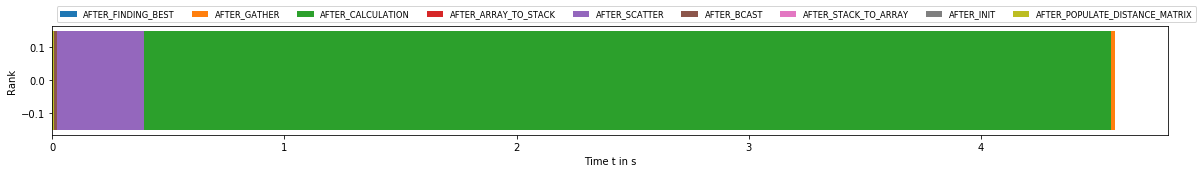

In [15]:
times.plot_single(0)

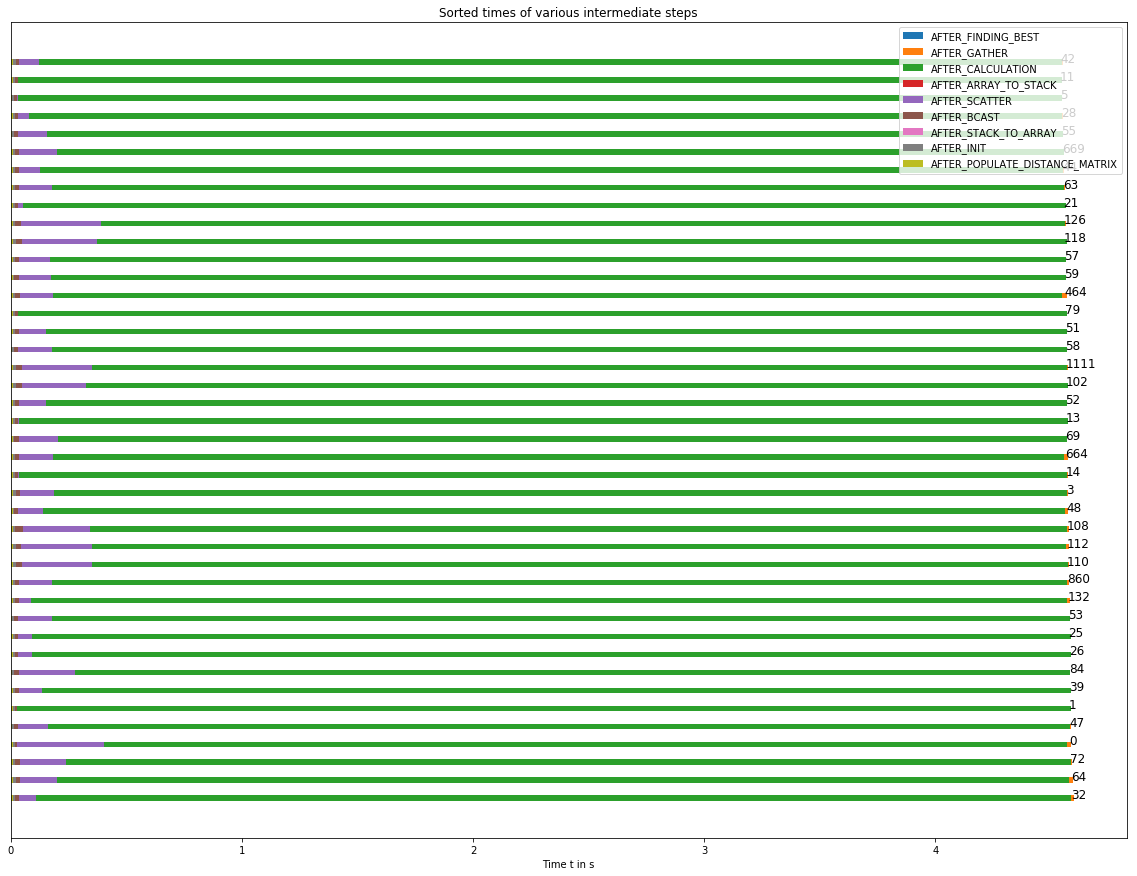

In [16]:
times.plot_all_sorted()

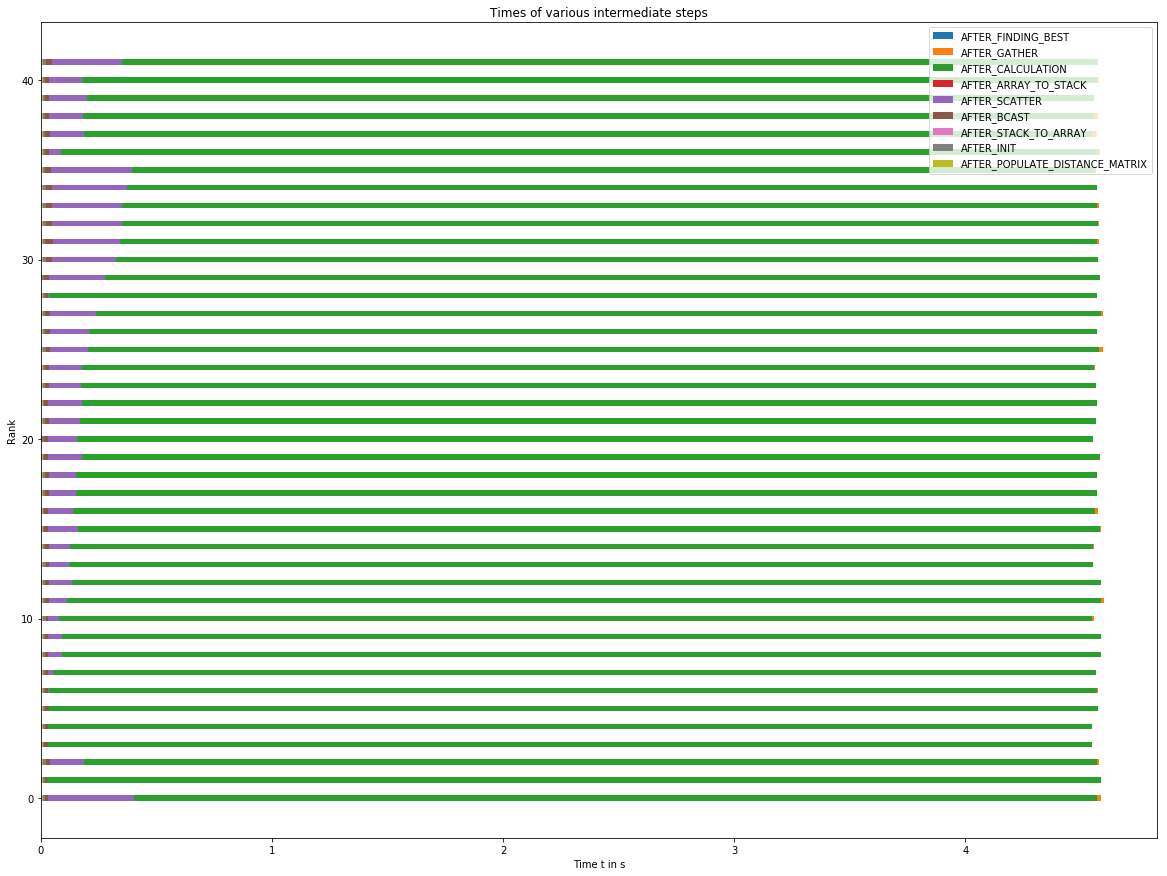

In [17]:
times.plot_all()

# Cityplot

In [18]:
import csv, matplotlib.pyplot as plt, matplotlib.patches as mpatches

In [19]:
def get_city_coords(filename):
    city_cords = {
        "city_names" : [],
        "city_citizens" : [],
        "x_cords" : [],
        "y_cords" : []
    }
    with open(filename, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\t')
        for row in csvreader:
            if len(row) == 4:
                city_cords["city_names"].append(row[0]) 
                city_cords["city_citizens"].append(float(row[1]))
                city_cords["y_cords"].append(float(row[2]))
                city_cords["x_cords"].append(float(row[3])) 
    return city_cords

class CityPlot:
    def __init__(self, city_cords, *title, figsize=(15,15), plot_names=True, city_col=(1, .7647058823529411, 0, 0.5), city_edge_col=(.5647058823529412, .047058823529411764, .24705882352941178, 0.5), border_width=1):
        if not title:
            title = "Map of " + str(len(city_cords["city_names"])) + " given cities"
        else:
            title = title[0]
            
        self.figure = plt.figure(1, figsize=figsize)
        self.subplot = self.figure.add_subplot(111, aspect='equal')
        plt.title(title, fontsize=20)
        plt.axis('off')
        self.city_cords = city_cords
        self.city_col = city_col
        self.city_edge_col = city_edge_col
        self.plot_names = plot_names
        self.border_width = border_width
    
    def plot_cities(self):
        border=0.1
        y_r = max(self.city_cords["x_cords"]) - min(self.city_cords["x_cords"])
        x_r = max(self.city_cords["y_cords"]) - min(self.city_cords["y_cords"])
        plt.xlim([min(self.city_cords["x_cords"]) - border * x_r, max(self.city_cords["x_cords"]) + border * x_r])
        plt.ylim([min(self.city_cords["y_cords"]) - border * y_r, max(self.city_cords["y_cords"]) + border * y_r])
        for i in range(len(self.city_cords["city_names"])):
            self.subplot.add_artist(plt.Circle((self.city_cords["x_cords"][i], self.city_cords["y_cords"][i]), self.city_cords["city_citizens"][i]*0.0000001, color=self.city_col, zorder=10, ec=self.city_edge_col, lw=self.border_width))        
            if self.plot_names:
                plt.text(self.city_cords["x_cords"][i], self.city_cords["y_cords"][i] + 0.2, self.city_cords["city_names"][i], color="k", fontsize=12)

    def plot_route(self, route, color=(.3411764705882353, .7803921568627451, .5215686274509804, 1)):
        if len(route) == 1:
            route_o = route
        elif len(route) == 3:
            route_o = route[2]
            
        x = []
        y = []
        for j in route_o:
            x.append(self.city_cords["x_cords"][j]) 
            y.append(self.city_cords["y_cords"][j])
            plt.scatter(self.city_cords["x_cords"][j], self.city_cords["y_cords"][j], color="k")
        plt.plot(x, y, zorder=11, label = "Number of cities: " + str(route[0]) + " Lenght: " + str(route[1]))
        plt.legend(loc=3)
        
    def show(self):
        plt.show()
            

In [20]:
# Found routes from result evaluation:
routes = results.get_routes()
for i in range(0, len(routes)):
    print("_____________________________________________________________________________________________________________________________\n")
    print("Index: " + str(i) + "\n\nNumber of cities: " + str(routes[i][0]) + "\tLength: " + str(routes[i][1]) + "\tRoute: " + str(routes[i][2]) + "\n")


_____________________________________________________________________________________________________________________________

Index: 0

Number of cities: 6	Length: 1568.9149169921875	Route: [0, 2, 4, 3, 5, 1, 0]

_____________________________________________________________________________________________________________________________

Index: 1

Number of cities: 6	Length: 1568.9149169921875	Route: [0, 1, 5, 3, 4, 2, 0]

_____________________________________________________________________________________________________________________________

Index: 2

Number of cities: 12	Length: 1734.4908447265625	Route: [0, 2, 6, 4, 3, 8, 11, 7, 5, 10, 9, 1, 0]

_____________________________________________________________________________________________________________________________

Index: 3

Number of cities: 12	Length: 1734.4908447265625	Route: [0, 1, 9, 10, 5, 7, 11, 8, 3, 4, 6, 2, 0]

______________________________________________________________________________________________________

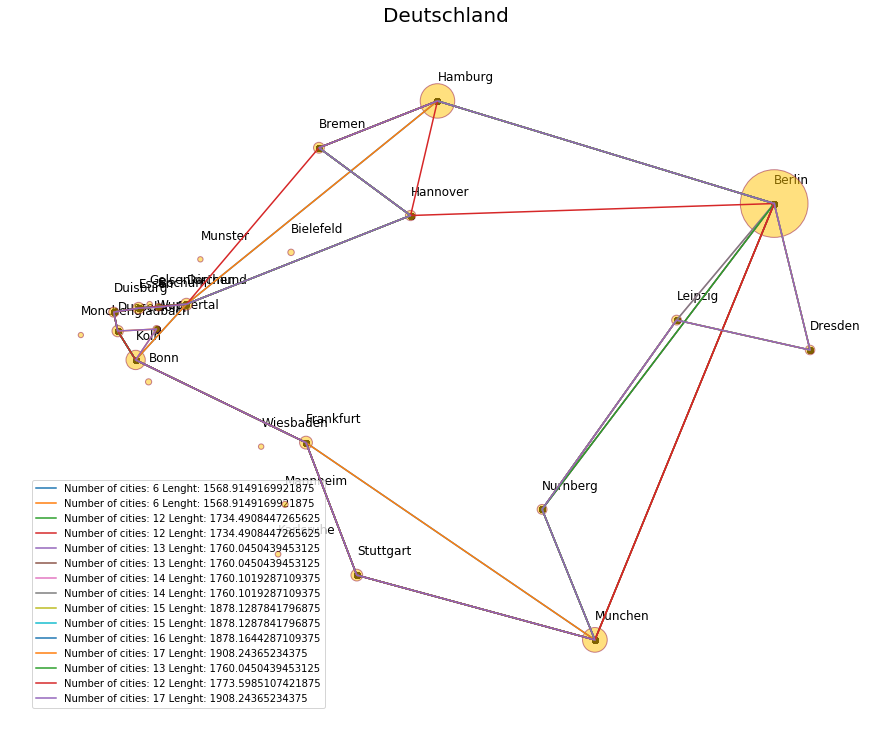

In [21]:
#route = [0,14,13,12,2,6,4,3,16,8,11,7,15,5,10,9,1,0] #17
#route = [0, 14, 13, 12, 2, 6, 4, 3, 8, 11, 7, 5, 10, 9, 1, 0] #15
#route = [0, 2, 4, 3, 5, 1, 0] 

city_lib = get_city_coords(cities_name)
city_plot = CityPlot(city_lib, "Deutschland")
city_plot.plot_cities()

# Plot all found routes in one plot
#city_plot.plot_route(routes[0])

# Plot all found routes in one plot
for route in routes:
    city_plot.plot_route(route)

# TSP in Python

Ohne Erdkrümmung

In [22]:
import copy, math, itertools

In [23]:
# x and y are tuples containing x an y coordinates of both points x = (x_c1, x_c2) and y = (y_c1, y_c2)
# Does not take earth curvature into account yet
def calc_distance(x, y):
    return math.sqrt((max(x) - min(x)) ** 2 + (max(y) - min(y)) ** 2)

In [24]:
def populate_distance_matrix(coords_lib):
    distance_lib = {}
    for city in coords_lib['city_names']:
        distance_lib[city] = {}
        distance_lib[city]['keys'] = copy.copy(coords_lib['city_names'])
        distance_lib[city]['keys'].remove(city)
        distance_lib[city]['distance'] = [calc_distance((coords_lib['x_cords'][coords_lib['city_names'].index(city)], coords_lib['x_cords'][coords_lib['city_names'].index(city2)]), (coords_lib['y_cords'][coords_lib['city_names'].index(city)], coords_lib['y_cords'][coords_lib['city_names'].index(city2)])) for city2 in distance_lib[city]['keys']]
    return distance_lib

def return_distance(distance_lib, city1, city2):
    return distance_lib[city1]['distance'][distance_lib[city1]['keys'].index(city2)]

def calc_route_distance(distance_lib, route):
    distance = 0
    for i in range(0, len(route)-1):
        distance = distance + return_distance(distance_lib, list(distance_matrix.keys())[route[route[i]]], list(distance_matrix.keys())[route[route[i+1]]])
    distance = distance + return_distance(distance_lib, list(distance_matrix.keys())[route[len(route)-1]], list(distance_matrix.keys())[route[0]])
    return distance

def get_shortest_route(distance_matrix, routes):
    shortest_distance = calc_route_distance(distance_matrix, routes[0])
    shortest_route = routes[0]
    for i in range(1, len(routes)):
        current_distance = calc_route_distance(distance_matrix, routes[i])
        if current_distance < shortest_distance:
            shortest_distance = current_distance
            shortest_route = routes[i]
    return shortest_distance, shortest_route

In [25]:
# Calculating distance matrix
distance_matrix = populate_distance_matrix(city_lib)

In [26]:
# Shortest found route from MPI calculation (6 Cities)
print("Length:\t" + str(calc_route_distance(distance_matrix, routes[4][2][:-1])))
print("Route:\t" + str(routes[4][2][:-1]))

Length:	40.54069153713735
Route:	[0, 1, 9, 10, 5, 7, 11, 8, 3, 4, 6, 2, 12]


In [27]:
# tsp_n <-- num_cities in MPI
tsp_n = 6
seed = list(np.arange(1, tsp_n))
seeds = list(itertools.permutations(seed, len(seed)))
seeds = [[0] + list(r) for r in seeds]

In [28]:
# Finding shortest route
shortest_distance, shortest_route = get_shortest_route(distance_matrix, seeds)

In [29]:
# Shortest found route from MPI calculation (6 Cities)
print("Length:\t" + str(shortest_distance))
print("Route:\t" + str(shortest_route))

Length:	20.110581083739106
Route:	[0, 3, 5, 2, 1, 4]


# TODO
Warum sind die nicht gleich? --> Vermutlich, weil die Erdkrümmung nicht berücksichtigt wurde...

TODO: Die Längenberechnung umschreiben